In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from matplotlib.colors import ListedColormap

In [6]:
class AdalineGD(object):
    def __init__(self, eta = 0.01, n_iter = 50, random_state = 1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state
        
    def fit(self, X, y):
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc = 0.0, scale = 0.01, size = 1 + X.shape[1])
        
        #에포크마다 누적된 비용함수의 제곱합(SSE)
        self.cost_ = []
        
        for i in range(self.n_iter):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            cost = (errors ** 2).sum() / 2.0
            self.cost_.append(cost)
        return self
    
    def net_input(self, X):
        return np.dot(X, self.w_[1:] + self.w_[0])
    
    def activation(self, X):
        return X
    
    def predict(self, X):
        return np.where(self.activation(self.net_input(X)) >= 0.0, 1, -1)

In [7]:
s = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
print('URL:', s)
df = pd.read_csv(s, header = None, encoding = 'utf-8')
df

URL: https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data


,0,1,2,3,4
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica


In [8]:
y = df.iloc[0:100, 4].values
y = np.where(y == 'Iris-setosa', -1, 1)
X = df.iloc[0:100, [0, 2]].values

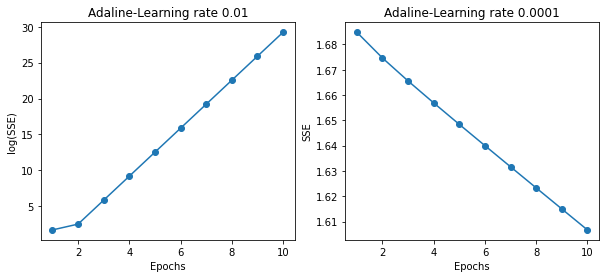

In [9]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4))
ada1 = AdalineGD(n_iter = 10, eta = 0.01).fit(X, y)
ax[0].plot(range(1, len(ada1.cost_) + 1), np.log10(ada1.cost_), marker = 'o')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('log(SSE)')
ax[0].set_title('Adaline-Learning rate 0.01')

ada2 = AdalineGD(n_iter = 10, eta = 0.0001).fit(X, y)
ax[1].plot(range(1, len(ada2.cost_) + 1), np.log10(ada2.cost_), marker = 'o')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('SSE')
ax[1].set_title('Adaline-Learning rate 0.0001')

plt.show()

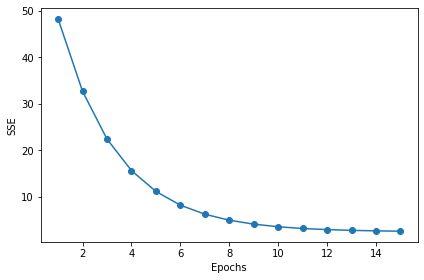

In [10]:
X_std = np.copy(X)
X_std[:, 0] = (X[:, 0] - X[:, 0].mean()) / X[:, 0].std()
X_std[:, 1] = (X[:, 1] - X[:, 1].mean()) / X[:, 1].std()

ada = AdalineGD(n_iter = 15, eta = 0.01)
ada.fit(X_std, y)
plt.plot(range(1, len(ada.cost_) + 1), ada.cost_, marker = 'o')
plt.xlabel('Epochs')
plt.ylabel('SSE')
plt.tight_layout()
plt.show()

In [29]:
class AdalineSGD(object):
    #shuffle: default가 True, bool, True 시 같은 반복이 되지 않도록 데이터를 섞음
    def __init__(self, eta = 0.01, n_iter = 10, shuffle = True, random_state = None):
        self.eta = eta
        self.n_iter = n_iter
        self.w_initialized = False
        self.shuffle = shuffle
        self.random_state = random_state
        
    def fit(self, X, y):
        self._initialize_weights(X.shape[1])
        self.cost_ = []
        for i in range(self.n_iter):
            
            #default = True
            if self.shuffle:
                X, y = self._shuffle(X, y)
            cost = []
            
            for xi, target in zip(X, y):
                cost.append(self._update_weights(xi, target))
            avg_cost = sum(cost) / len(y)
            self.cost_.append(avg_cost)
        return self
    
    def partial_fit(self, X, y):
        if not self.w_initialized:
            self._initialize_weights(X.shape[1])
            
        if y.ravel().shape[0] > 1:
            for xi, target in zip(X, y):
                self._update_weights(xi, target)
        else:
            self._update_weights(X, y)
        return self
    
    def _shuffle(self, X, y):
        r = self.rgen.permutation(len(y))
        return X[r], y[r]
    
    def _initialize_weights(self, m):
        self.rgen = np.random.RandomState(self.random_state)
        self.w_ = self.rgen.normal(loc = 0.0, scale = 0.0, size = 1 + m)
        self.w_initialized = True
        
    def _update_weights(self, xi, target):
        ouput = self.activation(self.net_input(xi))
        error = (target - ouput)
        self.w_[1:] += self.eta * xi.dot(error)
        self.w_[0] += self.eta * error
        cost = 0.5 * error ** 2
        return cost
    
    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]
    
    def activation(self, X):
        return X
    
    def predict(self, X):
        return np.where(self.activation(self.net_input(X) >= 0.0, 1, -1))

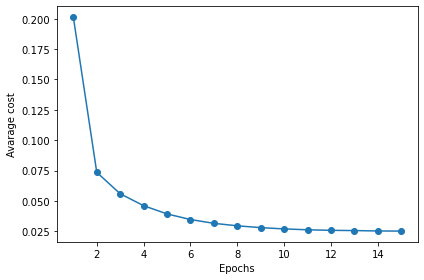

In [30]:
ada = AdalineSGD(n_iter = 15, eta = 0.01, random_state = 1)
ada.fit(X_std, y)
plt.plot(range(1, len(ada.cost_) + 1), ada.cost_, marker = 'o')
plt.xlabel('Epochs')
plt.ylabel('Avarage cost')
plt.tight_layout()
plt.show()

## test coding

In [12]:
a = np.array([[1], [2], [3]])
b = np.array([[1], [-1], [1]])
c = np.array([1, 0, 0, 4])

In [14]:
print('a:', a) 
print()
print('b:', b) 
print()
print('c:', c)

a: [[1]
 [2]
 [3]]

b: [[ 1]
 [-1]
 [ 1]]

c: [1 0 0 4]


In [15]:
#len(nd-array) = 배열안 모든 수
print('len(a):', len(a))
print('len(b):', len(b))
print('len(c):', len(c))

len(a): 3
len(b): 3
len(c): 4


In [16]:
print(np.random.permutation(len(a)))
print(np.random.permutation(len(b)))
print(np.random.permutation(len(c)))

[2 1 0]
[2 0 1]
[1 2 0 3]


In [25]:
a

array([[1],
       [2],
       [3]])

In [26]:
a.ravel()

array([1, 2, 3])

In [27]:
a.ravel().shape[0]

3